# Some regularizations on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
By [Zahra Taheri](https://github.com/zahta), November 1, 2020

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Define path to the directory

path = os.getcwd()

mypath = path+"\Fashion-MNIST"

os.chdir(mypath)

print(os.getcwd())

C:\Users\Zahra\github\Deep_Learning_F20_Assignments\Assignments\Assignment_Set_6\Fashion-MNIST files\Fashion-MNIST


## Loading Fashion-MNIST into NumPy arrays

In [3]:
from mlxtend.data import loadlocal_mnist

#load train_data and train_labels
train_data, train_labels= loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
#load test_data and test_labels
test_data, test_labels= loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

In [4]:
print(train_data.shape)   # 28*28=784
print(train_labels.shape)

(60000, 784)
(60000,)


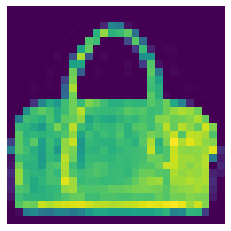

In [5]:
some_digit = train_data[11000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)#, cmap = mpl.cm.binary)
plt.axis("off")
plt.show()

In [6]:
from PIL import Image
import numpy as np

PIL_image = Image.fromarray(np.uint8(some_digit_image))

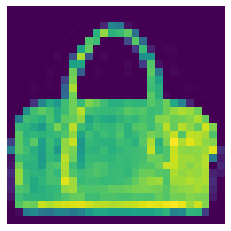

In [7]:
plt.imshow(PIL_image)
plt.axis("off")
plt.show()

## Preparation of the dataset

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
train_data= train_data.reshape((train_data.shape[0],28,28))
test_data= test_data.reshape((test_data.shape[0],28,28))

In [10]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [11]:
tensor_x2 = torch.Tensor(test_data) # transform to torch tensor
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2) # create your test dataset

In [12]:
tensor_y

tensor([9, 0, 0,  ..., 3, 0, 5])

In [13]:
#train_dataset[0]

## Building Feedforward Neural Networks with PyTorch

In [14]:
# import libraries
import torch
import torch.nn as nn

from torch.autograd import Variable
from torchsummary import summary

## L2 regularization

### Model A: 2 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [15]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

16


In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

### Create model class

In [17]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2:
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function (readout)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        #linear function 3 (readout)
        out = self.fc3(out)
        return out       
    

In [18]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [19]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5                [-1, 1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [20]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L2 regularization

In [21]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.5490452647209167. Accuracy: 79
Iteration: 1000. Loss: 0.5463058352470398. Accuracy: 81
Iteration: 1500. Loss: 0.43616917729377747. Accuracy: 83
Iteration: 2000. Loss: 0.4434066116809845. Accuracy: 82
Iteration: 2500. Loss: 0.40014100074768066. Accuracy: 83
Iteration: 3000. Loss: 0.3653157949447632. Accuracy: 85
Iteration: 3500. Loss: 0.47124138474464417. Accuracy: 85
Iteration: 4000. Loss: 0.4155188798904419. Accuracy: 85
Iteration: 4500. Loss: 0.33549395203590393. Accuracy: 85
Iteration: 5000. Loss: 0.31972867250442505. Accuracy: 86
Iteration: 5500. Loss: 0.35833287239074707. Accuracy: 86
Iteration: 6000. Loss: 0.5030900239944458. Accuracy: 86
Iteration: 6500. Loss: 0.40233394503593445. Accuracy: 86
Iteration: 7000. Loss: 0.3460851013660431. Accuracy: 86
Iteration: 7500. Loss: 0.35292717814445496. Accuracy: 86
Iteration: 8000. Loss: 0.3967834711074829. Accuracy: 86
Iteration: 8500. Loss: 0.20996347069740295. Accuracy: 86
Iteration: 9000. Loss: 0.350403338670730

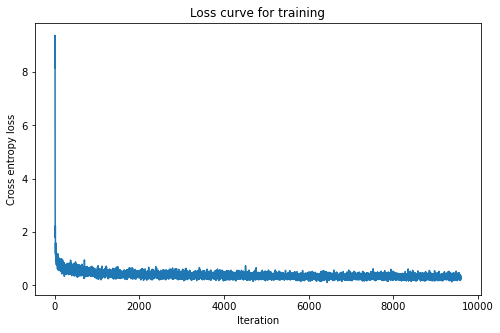

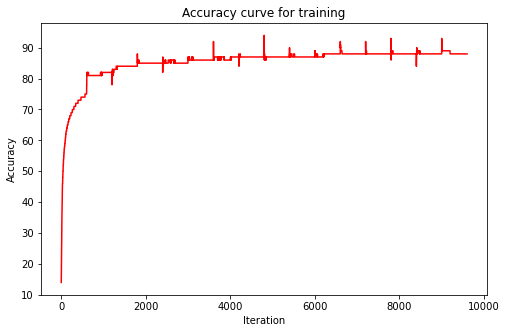

In [22]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [23]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-A.pkl")# only save parameters

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [24]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [26]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [27]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [28]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [29]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L2 regularization

In [30]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 1000. Loss: 0.4918474555015564. Accuracy: 81
Iteration: 2000. Loss: 0.5597603917121887. Accuracy: 83
Iteration: 3000. Loss: 0.44303128123283386. Accuracy: 83
Iteration: 4000. Loss: 0.6555835008621216. Accuracy: 84
Iteration: 5000. Loss: 0.40862977504730225. Accuracy: 85
Iteration: 6000. Loss: 0.39441603422164917. Accuracy: 85
Iteration: 7000. Loss: 0.5132167935371399. Accuracy: 85
Iteration: 8000. Loss: 0.29234403371810913. Accuracy: 85
Iteration: 9000. Loss: 0.48572102189064026. Accuracy: 85
Iteration: 10000. Loss: 0.29445114731788635. Accuracy: 84
Iteration: 11000. Loss: 0.38881373405456543. Accuracy: 86
Iteration: 12000. Loss: 0.36642637848854065. Accuracy: 85
Iteration: 13000. Loss: 0.5251083374023438. Accuracy: 86
Iteration: 14000. Loss: 0.36304742097854614. Accuracy: 86
Iteration: 15000. Loss: 0.32579195499420166. Accuracy: 86
Iteration: 16000. Loss: 0.2608204782009125. Accuracy: 86
Iteration: 17000. Loss: 0.32004863023757935. Accuracy: 85
Iteration: 18000. Loss: 0.260

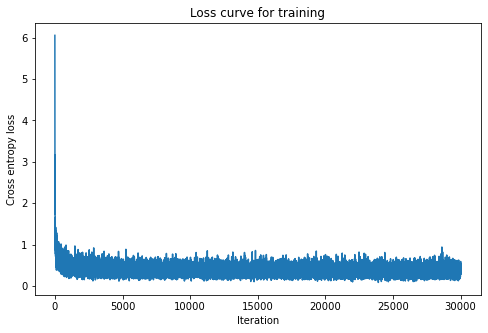

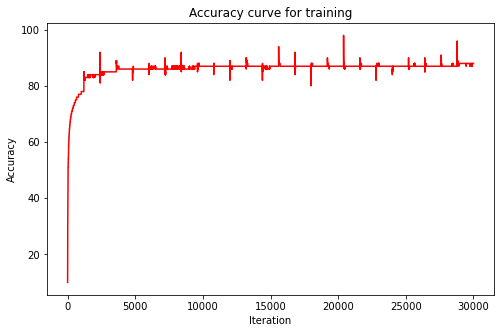

In [31]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [32]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-B.pkl")# only save parameters

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [33]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [34]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [35]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [36]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        
        out = self.f6(out)
        
        return out       
    

In [37]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [38]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
            Linear-9               [-1, 1, 100]          30,100
             ReLU-10               [-1, 1, 100]               0
           Linear-11                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params: 200,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [39]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
LAMBDA = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L2 regularization

In [40]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.7607389092445374. Accuracy: 74
Iteration: 1000. Loss: 0.7029391527175903. Accuracy: 81
Iteration: 1500. Loss: 0.5644179582595825. Accuracy: 81
Iteration: 2000. Loss: 0.30205273628234863. Accuracy: 83
Iteration: 2500. Loss: 0.43762171268463135. Accuracy: 83
Iteration: 3000. Loss: 0.38586515188217163. Accuracy: 85
Iteration: 3500. Loss: 0.513348400592804. Accuracy: 83
Iteration: 4000. Loss: 0.3812751770019531. Accuracy: 84
Iteration: 4500. Loss: 0.48402032256126404. Accuracy: 84
Iteration: 5000. Loss: 0.502432644367218. Accuracy: 85
Iteration: 5500. Loss: 0.5876505970954895. Accuracy: 84
Iteration: 6000. Loss: 0.6607846021652222. Accuracy: 85
Iteration: 6500. Loss: 0.4949927031993866. Accuracy: 84
Iteration: 7000. Loss: 0.24174714088439941. Accuracy: 86
Iteration: 7500. Loss: 0.6807226538658142. Accuracy: 84
Iteration: 8000. Loss: 0.3149530291557312. Accuracy: 84
Iteration: 8500. Loss: 0.42691347002983093. Accuracy: 85
Iteration: 9000. Loss: 0.2752499580383301. Ac

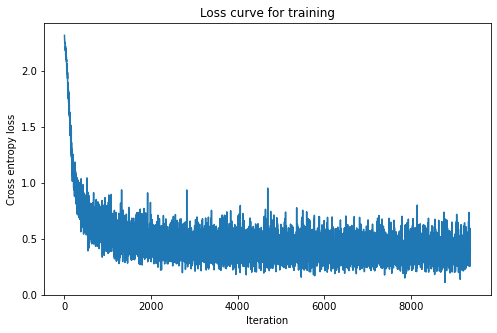

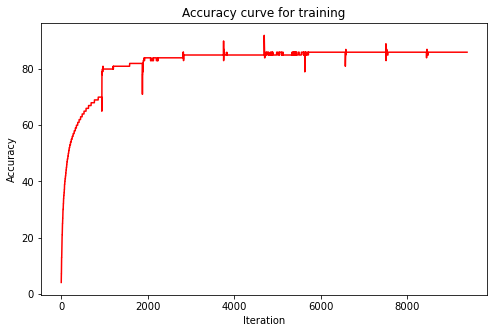

In [41]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [42]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-C.pkl")# only save parameters

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [15]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [17]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [18]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        
        return out       
    

In [19]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [21]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
LAMBDA = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model with L2 norm

In [22]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 0.5741776823997498. Accuracy: 80
Iteration: 1000. Loss: 0.4984549283981323. Accuracy: 82
Iteration: 1500. Loss: 0.37621182203292847. Accuracy: 83
Iteration: 2000. Loss: 0.3781629204750061. Accuracy: 84
Iteration: 2500. Loss: 0.3387756943702698. Accuracy: 84
Iteration: 3000. Loss: 0.3005916476249695. Accuracy: 85
Iteration: 3500. Loss: 0.21213459968566895. Accuracy: 85
Iteration: 4000. Loss: 0.2843926250934601. Accuracy: 86
Iteration: 4500. Loss: 0.4047917425632477. Accuracy: 85
Iteration: 5000. Loss: 0.28453418612480164. Accuracy: 86
Iteration: 5500. Loss: 0.4685816466808319. Accuracy: 86
Iteration: 6000. Loss: 0.3326895833015442. Accuracy: 85
Iteration: 6500. Loss: 0.2759743630886078. Accuracy: 86
Iteration: 7000. Loss: 0.3286040425300598. Accuracy: 86
Iteration: 7500. Loss: 0.2882852554321289. Accuracy: 87
Iteration: 8000. Loss: 0.2734530568122864. Accuracy: 87
Iteration: 8500. Loss: 0.32497110962867737. Accuracy: 86
Iteration: 9000. Loss: 0.43353956937789917. A

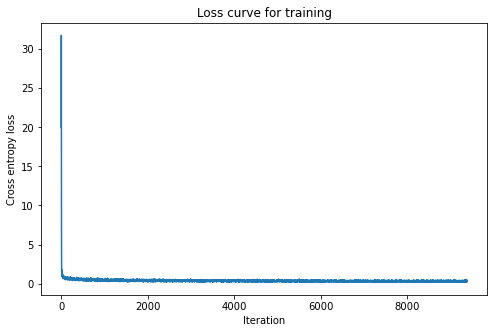

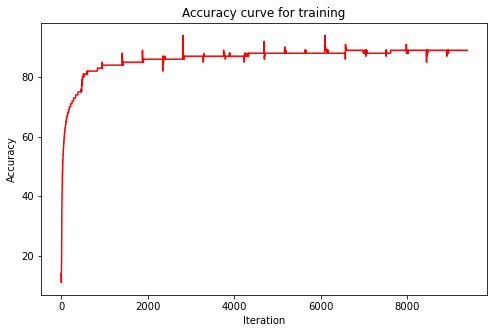

In [23]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [24]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-D.pkl")# only save parameters

## L1 regularization

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [25]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [27]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [28]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        
        out = self.f6(out)
        
        return out       
    

In [29]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [30]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
            Linear-9               [-1, 1, 100]          30,100
             ReLU-10               [-1, 1, 100]               0
           Linear-11                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params: 200,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [31]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model with L1 regularization

In [32]:
# Train the model

LAMBDA = 0.001
train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        '''
        L1 regularization
        '''
        l1_regularization = torch.tensor(0).long()
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).long()
            
        loss += LAMBDA * l1_regularization
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 6.7012763023376465. Accuracy: 76
Iteration: 1000. Loss: 6.549015998840332. Accuracy: 81
Iteration: 1500. Loss: 6.52647590637207. Accuracy: 80
Iteration: 2000. Loss: 6.647714138031006. Accuracy: 83
Iteration: 2500. Loss: 6.555042266845703. Accuracy: 84
Iteration: 3000. Loss: 6.570957183837891. Accuracy: 84
Iteration: 3500. Loss: 6.618013381958008. Accuracy: 85
Iteration: 4000. Loss: 6.63817834854126. Accuracy: 85
Iteration: 4500. Loss: 6.632719993591309. Accuracy: 85
Iteration: 5000. Loss: 6.697399139404297. Accuracy: 83
Iteration: 5500. Loss: 6.560423374176025. Accuracy: 85
Iteration: 6000. Loss: 7.005623817443848. Accuracy: 84
Iteration: 6500. Loss: 6.587013244628906. Accuracy: 86
Iteration: 7000. Loss: 6.682181358337402. Accuracy: 85
Iteration: 7500. Loss: 6.62949275970459. Accuracy: 86
Iteration: 8000. Loss: 6.754425525665283. Accuracy: 86
Iteration: 8500. Loss: 6.463537693023682. Accuracy: 86
Iteration: 9000. Loss: 6.781626224517822. Accuracy: 85


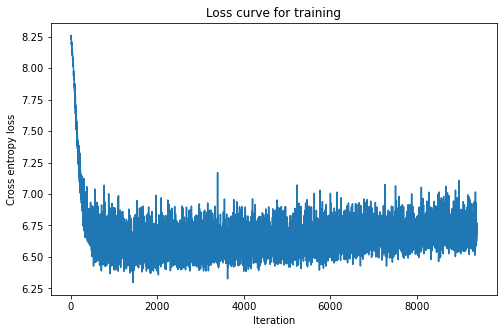

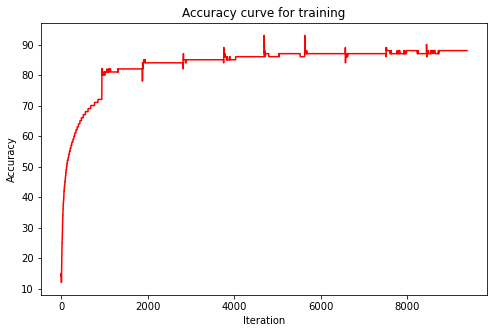

In [33]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [34]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-C-l1.pkl")# only save parameters

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [35]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [37]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [38]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        
        return out       
    

In [39]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [40]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [41]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model with L1 regularization

In [42]:
# Train the model

LAMBDA = 0.001
train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        '''
        L1 regularization
        '''
        l1_regularization = torch.tensor(0).long()
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).long()
            
        loss += LAMBDA * l1_regularization
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).to(device))
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 5.084341049194336. Accuracy: 78
Iteration: 1000. Loss: 4.99135684967041. Accuracy: 83
Iteration: 1500. Loss: 5.152750492095947. Accuracy: 83
Iteration: 2000. Loss: 5.1385345458984375. Accuracy: 83
Iteration: 2500. Loss: 4.9921770095825195. Accuracy: 84
Iteration: 3000. Loss: 5.020310878753662. Accuracy: 84
Iteration: 3500. Loss: 4.95637321472168. Accuracy: 85
Iteration: 4000. Loss: 5.184364318847656. Accuracy: 85
Iteration: 4500. Loss: 5.041792392730713. Accuracy: 85
Iteration: 5000. Loss: 5.023127555847168. Accuracy: 85
Iteration: 5500. Loss: 4.932234287261963. Accuracy: 86
Iteration: 6000. Loss: 4.935850620269775. Accuracy: 86
Iteration: 6500. Loss: 4.881418228149414. Accuracy: 85
Iteration: 7000. Loss: 4.9341840744018555. Accuracy: 86
Iteration: 7500. Loss: 4.9832377433776855. Accuracy: 86
Iteration: 8000. Loss: 4.929264545440674. Accuracy: 86
Iteration: 8500. Loss: 4.875833034515381. Accuracy: 86
Iteration: 9000. Loss: 4.9644551277160645. Accuracy: 86


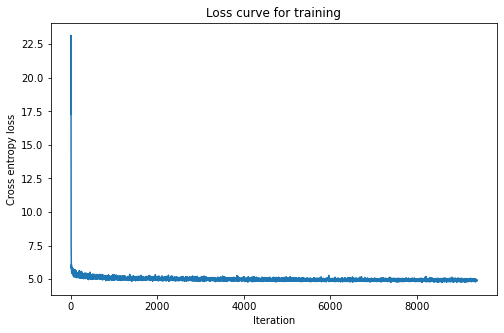

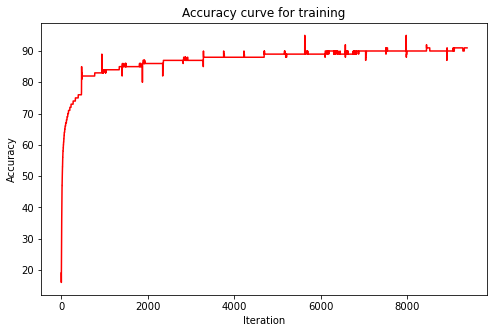

In [43]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [44]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-D-l1.pkl")# only save parameters

##  Data Augmentation

### Save images as `png` extensions in order to use `torchvisions.datasets.ImageFolder` and `torchvision.transforms`

In [15]:
mypath_train = mypath+"\\train"

#for i in range(train_data.shape[0]):
#    label = train_labels[i]
#    dir = os.path.join(mypath_train, str(label))
#    os.chdir(dir)
#    image = train_data[i].reshape(28, 28)
#    PIL_image = Image.fromarray(np.uint8(image))
#    a = str(i)+ ".png"
#    PIL_image.save(a)

In [16]:
mypath_test = mypath+"\\test"

#for i in range(test_data.shape[0]):
#    label = test_labels[i]
#    dir = os.path.join(mypath_test, str(label))
#    os.chdir(dir)
#    image = test_data[i].reshape(28, 28)
#    PIL_image = Image.fromarray(np.uint8(image))
#    a = str(i)+ ".png"
#    PIL_image.save(a)

In [17]:
# Restarting the Kernel

#import os
#os._exit(00)

In [18]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import PIL

In [19]:
train_transforms = transforms.Compose([
    #transforms.RandomRotation(degrees=20),
    #transforms.RandomCrop(size=(28, 28)),
    #transforms.ColorJitter(hue=.05, saturation=.05),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.25, 0.25),
                                        resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

train_dset = datasets.ImageFolder(mypath_train, transform=train_transforms)
test_dset = datasets.ImageFolder(mypath_test, transform=test_transforms)

In [20]:
print(train_dset[10][0].shape)

torch.Size([3, 28, 28])


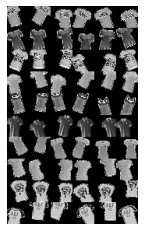

In [21]:
def show_dataset(dataset, n=6):
        img = np.vstack((np.hstack((np.asarray(transforms.functional.to_pil_image(dataset[i][0])) for _ in range(n)))
                   for i in range(10)))
        plt.imshow(img)
        plt.axis('off')
        
show_dataset(train_dset)

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [22]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [23]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dset, batch_size=batch_size,  shuffle=False)

In [24]:
input_dim = 3*28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [25]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        
        out = self.f6(out)
        
        return out       
    

In [26]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=2352, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [27]:
summary(model, (1,3*28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]         235,300
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
            Linear-9               [-1, 1, 100]          30,100
             ReLU-10               [-1, 1, 100]               0
           Linear-11                [-1, 1, 10]           1,010
Total params: 357,010
Trainable params: 357,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [28]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for images, labels in train_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 3*28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*28*28).to(device))
                else:
                    images = Variable(images.view(-1, 3*28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 2.2816505432128906. Accuracy: 22
Iteration: 1000. Loss: 1.9803636074066162. Accuracy: 21
Iteration: 1500. Loss: 1.6149300336837769. Accuracy: 43
Iteration: 2000. Loss: 1.4115705490112305. Accuracy: 47
Iteration: 2500. Loss: 1.3622136116027832. Accuracy: 54
Iteration: 3000. Loss: 1.0374010801315308. Accuracy: 60
Iteration: 3500. Loss: 1.1496188640594482. Accuracy: 61
Iteration: 4000. Loss: 1.152545690536499. Accuracy: 64
Iteration: 4500. Loss: 1.026536464691162. Accuracy: 63
Iteration: 5000. Loss: 1.0805940628051758. Accuracy: 65
Iteration: 5500. Loss: 1.1020151376724243. Accuracy: 64
Iteration: 6000. Loss: 0.9146216511726379. Accuracy: 65
Iteration: 6500. Loss: 1.0521332025527954. Accuracy: 66
Iteration: 7000. Loss: 0.9449040293693542. Accuracy: 66
Iteration: 7500. Loss: 0.8649071455001831. Accuracy: 68
Iteration: 8000. Loss: 0.9161742925643921. Accuracy: 68
Iteration: 8500. Loss: 1.0556538105010986. Accuracy: 68
Iteration: 9000. Loss: 0.8235880732536316. Accuracy

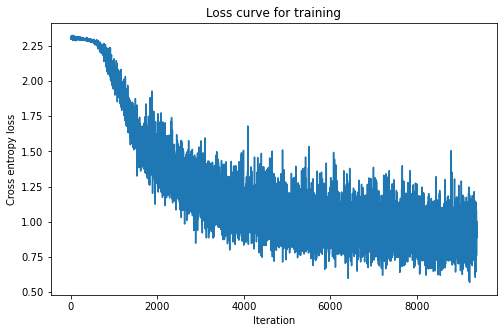

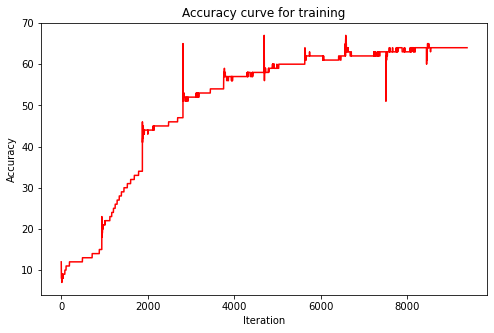

In [30]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [31]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-C-aug.pkl")# only save parameters

### Model D: 3 Hidden Layers Feedforward Neural Network

In [32]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomCrop(size=(28, 28)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    #transforms.RandomAffine(degrees=(-30, 30), translate=(0.25, 0.25),
    #                                    resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5), std=(0.5))
])

train_dset = datasets.ImageFolder(mypath_train, transform=train_transforms)
test_dset = datasets.ImageFolder(mypath_test, transform=test_transforms)

In [33]:
print(train_dset[10][0].shape)

torch.Size([3, 28, 28])


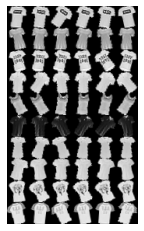

In [34]:
def show_dataset(dataset, n=6):
        img = np.vstack((np.hstack((np.asarray(transforms.functional.to_pil_image(train_dset[i][0])) for _ in range(n)))
                   for i in range(10)))
        plt.imshow(img)
        plt.axis('off')
        
show_dataset(train_dset)

#### Make dataset iterable

In [35]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [36]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dset, batch_size=batch_size,  shuffle=False)

In [37]:
input_dim = 3*28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [38]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        
        return out       
    

In [39]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel(
  (f1): Linear(in_features=2352, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [40]:
summary(model, (1,3*28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         602,368
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 10]           1,290
Total params: 636,554
Trainable params: 636,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 2.43
Estimated Total Size (MB): 2.44
----------------------------------------------------------------


In [41]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
# Train the model

train_loss = []
train_accuracy = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    # Calculate Accuracy         
    correct_1 = 0
    total_1 = 0
    for images, labels in train_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 3*28*28).to(device))
            labels = Variable(labels.to(device))
        else:
            images = Variable(images.view(-1, 3*28*28))
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        '''
        Save accuracy to draw accuracy curve
        '''
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
        # Total number of labels
        total_1 += labels.size(0)
           
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
                    correct_1 += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
        else:                
                    correct_1 += (predicted == labels).sum()
            
        accuracy = 100 * correct_1 // total_1
        train_accuracy.append(accuracy)
        ''''''
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        '''
        Save loss to draw accuracy curve
        '''
        train_loss.append(loss)
        ''''''
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 3*28*28).to(device))
                else:
                    images = Variable(images.view(-1, 3*28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))
            

Iteration: 500. Loss: 2.236178398132324. Accuracy: 29
Iteration: 1000. Loss: 2.1297543048858643. Accuracy: 51
Iteration: 1500. Loss: 1.9876383543014526. Accuracy: 51
Iteration: 2000. Loss: 1.7973318099975586. Accuracy: 46
Iteration: 2500. Loss: 1.6747509241104126. Accuracy: 50
Iteration: 3000. Loss: 1.5846844911575317. Accuracy: 54
Iteration: 3500. Loss: 1.4942927360534668. Accuracy: 56
Iteration: 4000. Loss: 1.3300617933273315. Accuracy: 57
Iteration: 4500. Loss: 1.3114268779754639. Accuracy: 58
Iteration: 5000. Loss: 1.1940268278121948. Accuracy: 59
Iteration: 5500. Loss: 1.3497331142425537. Accuracy: 60
Iteration: 6000. Loss: 1.1012639999389648. Accuracy: 61
Iteration: 6500. Loss: 1.0724066495895386. Accuracy: 62
Iteration: 7000. Loss: 1.220318078994751. Accuracy: 62
Iteration: 7500. Loss: 0.9768035411834717. Accuracy: 64
Iteration: 8000. Loss: 1.1247761249542236. Accuracy: 64
Iteration: 8500. Loss: 1.1057277917861938. Accuracy: 65
Iteration: 9000. Loss: 1.0454074144363403. Accuracy

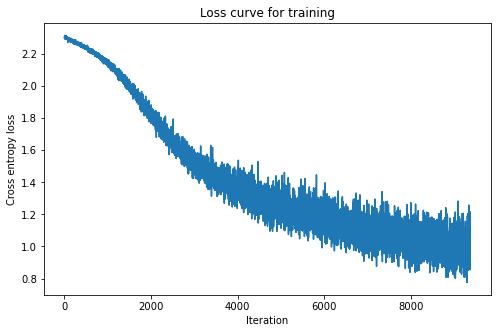

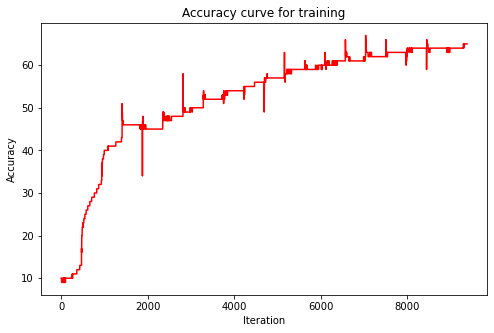

In [43]:
#Plots the loss and accuracy curves

plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for training")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(train_accuracy)), train_accuracy, c='r')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy curve for training")
plt.show()

In [44]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), path+"\\regularization_fashion-mnist-D-aug.pkl")# only save parameters